In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("netflix.csv")

## **EDA**

In [ ]:
data.head(15)

# when we observe the data we can see that there are nested values in few columns of the DataFrame like cast,director,actor and listed_in

In [ ]:
data.info()

# We can oberve that the only release year is a int column all others are object (string) type
# We can also observe that there are few columns which has null values as well

# Step_1--> Check for the duplicate rows

In [ ]:
np.any(data.duplicated())

# This will give boolean True as output if data.duplicated gives True for any row

# Step_2--> Check For Null values in our data

In [ ]:
# This gives number of null values in each column
data.isna().sum()



In [ ]:
# number of unique value in each column
data.nunique()

# Step_3--> Unnesting

In [ ]:
# When we look at our data we can see that there are some columns where data is nested so we need to unnest the data to perform EDA
# Columns having nested values are -->
# --> director
# -->cast
# --> actors
# --> listed_in

In [ ]:
# Unnesting of director column
data_1=data.loc[:,["title","director"]]
data_1
data_1["director"]=data_1['director'].str.split(",") # It creates a list of comma separated values
data_1=data_1.explode("director") # In order to explode to work it need the comma separated value of a particular column should be in list form
data_1


In [ ]:
# Unnesting of cast column
data_2=data.loc[:,["title","cast"]]
data_2["cast"]=data_2['cast'].str.split(",")
data_2=data_2.explode("cast")
data_2

In [ ]:
# Unnesting of country column
data_3=data.loc[:,["title","country"]]
data_3["country"]=data_3["country"].str.split(",")
data_3=data_3.explode("country")
data_3


In [ ]:
# Unnesting of listed_in column
data_4=data.loc[:,["title","listed_in"]]
data_4["listed_in"]=data_4["listed_in"].str.split(",")
data_4=data_4.explode("listed_in")
data_4

In [ ]:
# Merging these 4 unnested rows
data_5=data_1.merge(data_2,on="title",how="inner")
data_6=data_5.merge(data_3,on="title",how="inner")
data_7=data_6.merge(data_4,on="title",how="inner")
data_7

In [ ]:
data_7.isna().sum()

In [ ]:
data_7["director"].fillna("Unknown Director",inplace=True)
data_7["cast"].fillna("Unknown Actor",inplace=True)



In [ ]:
# merging data with the other columns of original data
data_new = data_7.merge(data[['show_id','type', 'title', 'date_added', 'release_year','rating', 'duration']],
                  on = 'title' ,
                  how = 'left')
# We didn't add the description column purposefully here bcz it doesn't help us in analysis

In [ ]:
data_new.head()

In [ ]:
data_new.shape

(202065, 11)

In [ ]:
data_new.isna().sum()

In [ ]:
# We observe that duration column has only 3 null values so we need to handle it first

In [ ]:
data_new[data_new["duration"].isna()]

# When we observe the rating column for the rows where duration is missing we see that rating column has value in minutes

,title,director,cast,country,listed_in,show_id,type,date_added,release_year,rating,duration
126582,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,Movies,s5542,Movie,"April 4, 2017",2017,74 min,NaN
131648,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,Movies,s5795,Movie,"September 16, 2016",2010,84 min,NaN
131782,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,Movies,s5814,Movie,"August 15, 2016",2015,66 min,NaN


In [ ]:
# Replacing the three values of duration with corresponding three values of rating

data_new.loc[data_new['duration'].isna(),'duration']

In [ ]:
data_new.loc[data_new['duration'].isna(),'duration'].fillna(data_new['rating'])

In [ ]:
# filling the null values of duration column corresponding the rating column
data_new.loc[data_new['duration'].isnull(),'duration'] = data_new.loc[data_new['duration'].isnull(),'duration'].fillna(data_new['rating'])

In [ ]:
data_new.isna().sum()

Changing the 3 valuesof rating column which are not appropriate for rating and converting into non rating (**NR**) values

In [ ]:
data_new.loc[data_new['rating'].str.contains('min',na=False),'rating']

126582    74 min
131648    84 min
131782    66 min
Name: rating, dtype: object

In [ ]:
data_new.loc[data_new['rating'].str.contains('min',na=False),'rating'] = 'NR'


In [ ]:
data_new['rating'].fillna('NR', inplace=True)

In [ ]:
data_new["rating"].isna().sum()

# We can see now the null value of rating column is also handled

In [ ]:
data_new.isna().sum()

Handling the 'NaT' values of date_added column

In [ ]:
data_new.loc[data_new['date_added'].isnull()]

In [ ]:
modes = data_new.groupby('release_year')['date_added'].apply(lambda x: x.mode().iloc[0])
modes

In [ ]:
# Fill null values of date_added based on the modes
data_new['date_added'] = data_new.apply(lambda row: modes[row['release_year']] if pd.isna(row['date_added']) else row['date_added'], axis=1)

In [ ]:
data_new.isnull().sum()

Handling the missing values of 'country' column

In [ ]:
# checking null values in the country
data_new.loc[data_new['country'].isnull()]

In [ ]:
# checking null values in country columns where  director are unique
data_new.loc[data_new['country'].isnull()]['director'].nunique()

378

In [ ]:
for i in data_new[data_new['country'].isnull()]['director'].unique():
  if i in data_new[~data_new['country'].isnull()]['director'].unique():
    imp = data_new[data_new['director'] == i]['country'].mode().values[0]
    data_new.loc[data_new['director'] == i, 'country'] = data_new.loc[data_new['director'] == i, 'country'].fillna(imp)

In [ ]:
data_new.isnull().sum()

In [ ]:
data_new

In [ ]:
# Performing the same ritual for columns with unique actors

for i in data_new[data_new['country'].isnull()]['cast'].unique():
  if i in data_new[~data_new['country'].isnull()]['cast'].unique():
    imp = data_new[data_new['cast'] == i]['country'].mode().values[0]
    data_new.loc[data_new['cast'] == i, 'country'] = data_new.loc[data_new['cast'] == i, 'country'].fillna(imp)

In [ ]:
data_new.isnull().sum()

In [ ]:
# Replacing the rest of the Values with the "unknown country"

In [ ]:
data_new["country"].fillna("unknown country",inplace=True)

In [ ]:
data_new.isnull().sum()

In [ ]:
data_new.info()

In [ ]:
# When we observe the duration column we see its object data type we want to take out the movies type and make it integer to get the better statistics

In [ ]:
data_new['duration']= data_new['duration'].str.replace(" min","")

In [ ]:
data_new['new_duration'] = data_new['duration'].copy()

In [ ]:
data_new

In [ ]:
# Now to delete all the objects that contain season in it to get the duration for movies only

In [ ]:
data_new.loc[data_new['new_duration'].str.contains('Season'), 'new_duration'] = 0

In [ ]:
# Change the data type of

data_new['new_duration'] = data_new['new_duration'].astype(int)

In [ ]:
# finding the statical information about this column
data_new['new_duration'].describe()

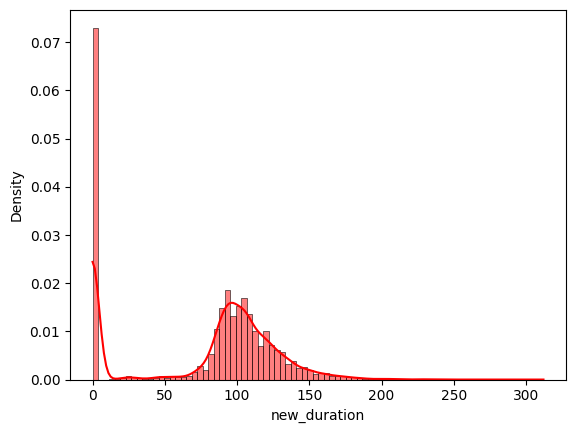

In [ ]:
sns.histplot(data_new['new_duration'], kde=True, stat="density", color='red')
plt.show()

We observe that the maximum duration of movies is 312 min and mean is around 77 min.
so the new duration column is divided in categories

In [ ]:
bins1 = [-1,1,50,80,100,120,150,200,315]
labels1 = ['<1','1-50','50-80','80-100','100-120','120-150','150-200','200-315']
data_new['new_duration'] = pd.cut(data_new['new_duration'], bins=bins1, labels = labels1 )

In [ ]:
data_new['new_duration']

In [ ]:
data_new.loc[~data_new['duration'].str.contains('Season'),'duration'] = data_new.loc[~data_new['duration'].str.contains('Season'),'new_duration']

In [ ]:
data_new["duration"]

In [ ]:
data_new.drop(columns=['new_duration'], inplace=True)


In [ ]:
data_new

In [ ]:
data_new['modified_date'] = data_new['date_added'].str.strip()
data_new['modified_date'] = pd.to_datetime(data_new['modified_date'] )


Halt_point

--> Data is saved here for the visual analysis



In [ ]:
data_NEW=data_new.copy()


In [ ]:
data_NEW

In [ ]:
# Use .dt.isocalendar() to get year, week number, and weekday
calender_data = data_NEW['modified_date'].dt.isocalendar()

In [ ]:
data_NEW['month'] = data_NEW['modified_date'].dt.month

In [ ]:
data_NEW['week'] = calender_data['week']

In [ ]:
data_NEW['year'] = calender_data['year']

In [ ]:
# Map month names to quarters using the month_to_quarter dictionary
month_to_quarter = {
    1: 'Q1',
    2: 'Q1',
    3: 'Q1',
    4: 'Q2',
    5: 'Q2',
    6: 'Q2',
    7: 'Q3',
    8: 'Q3',
    9: 'Q3',
    10: 'Q4',
    11: 'Q4',
    12: 'Q4'
}


In [ ]:
data_NEW['quarter'] = data_NEW['month'].map(month_to_quarter)

# VISUAL_ANALYSIS

In [ ]:
df=data_NEW.copy()
df

***Analysis_1***

In [ ]:
# Find the distribution of movies based on Type
df_1=df.groupby('type')["title"].nunique().reset_index()

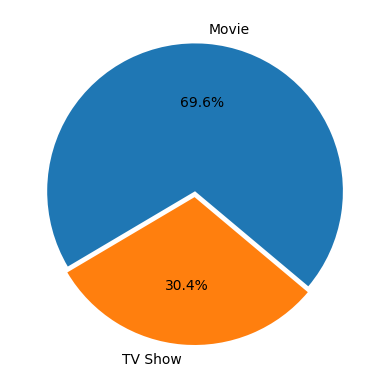

In [ ]:
plt.pie(df_1['title'], explode=(0.02, 0.02), labels = df_1['type'], autopct='%.1f%%', startangle=-40)
plt.show()

**Observation and insight**

--> We can see that approximately 70 % content watched on netflix are movies are 30 % are TV series

--> Proportionate addition of movies and TV series will take the buisness at more growth

***Analysis_2***

In [ ]:
# find the number  distinct title on the basis of listed_in(Category)

In [ ]:
df.groupby('listed_in').agg({'title':'nunique'}).sort_values('title', ascending = False).reset_index()

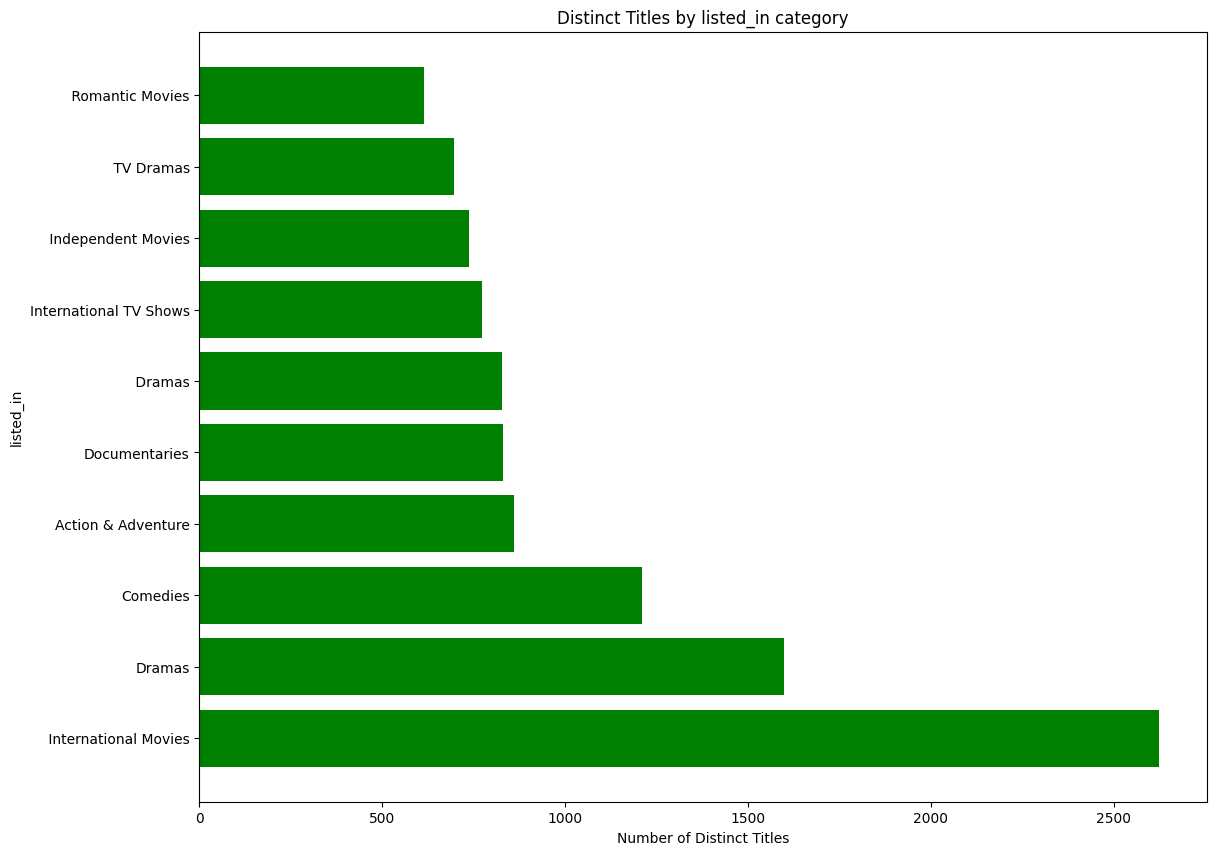

In [ ]:
# plot the top  10 genere
df1 = df.groupby('listed_in').agg({'title':'nunique'}).sort_values('title', ascending = False).reset_index().head(10)
plt.figure(figsize=(13, 10))
plt.barh(df1['listed_in'], df1['title'], color='g')
# plt.xticks(rotation=90)
plt.ylabel('listed_in')
plt.xlabel('Number of Distinct Titles')
plt.title('Distinct Titles by listed_in category')
plt.show()



**Insight:**

--> International Movies take the highest place in the list of most consumed content and we know from the above analysis that movies in the duration range of 100 min are the most watched.

--> More of international movies with average duration of around hundred min will enhance the growth

***Analysis_3***

In [ ]:
# Finding the frequency of content per country
df.groupby('country').agg({'title': 'nunique'}).sort_values(by='title', ascending=False)

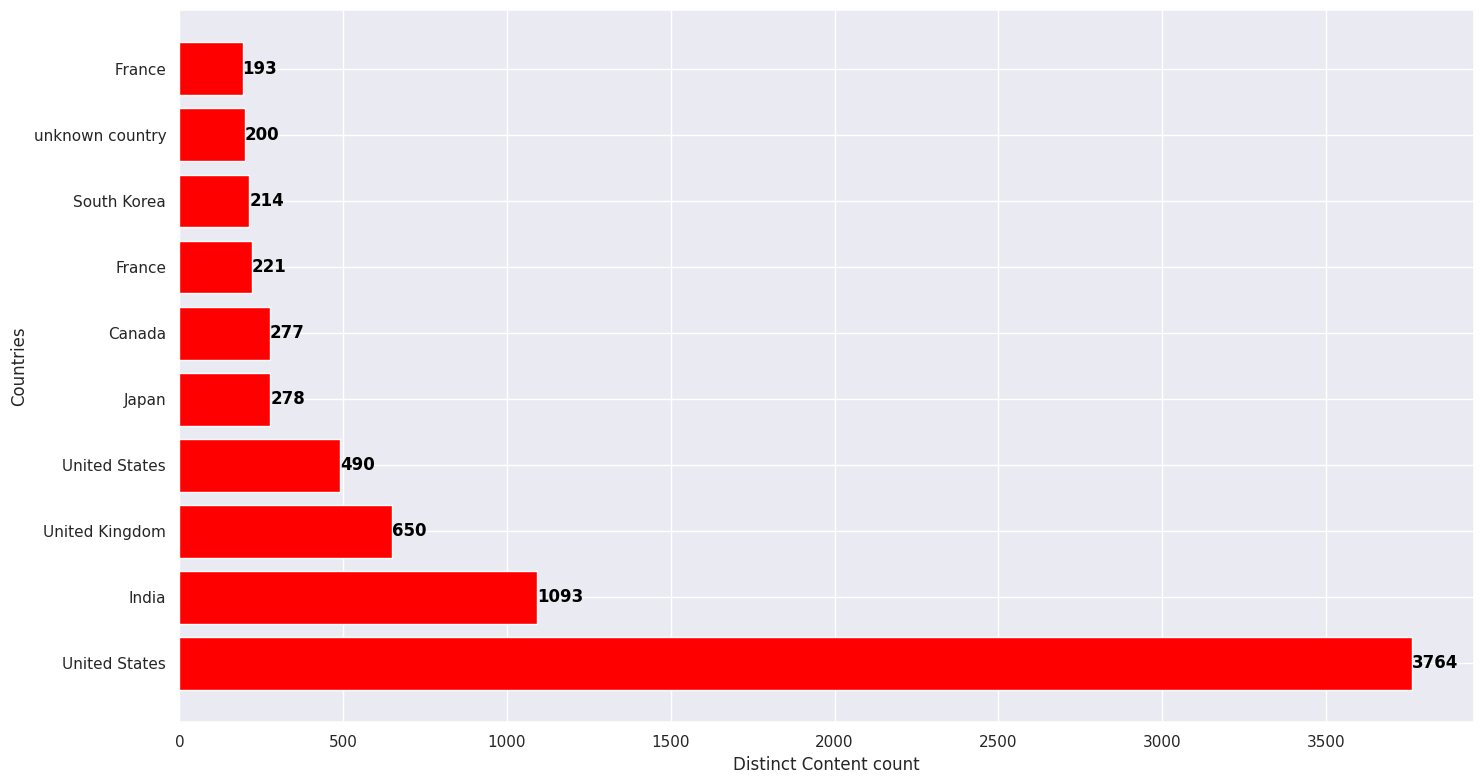

In [ ]:
df1 = df.groupby('country').agg({'title': 'nunique'}).sort_values(by='title', ascending=False).reset_index().head(10)
plt.figure(figsize=(15,8))
plt.barh(df1['country'], df1['title'],color="red")
plt.xlabel('Distinct Content count')
plt.ylabel('Countries')


for index, value in enumerate(df1['title']):
    plt.text(value, index, str(value), va='center', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

***Analysis_4***

In [ ]:
# Analyse the Content produced on NETFLIX based on ratings given to content category
df1 = df.groupby('rating').agg({'title': 'nunique'}).sort_values(by='title', ascending=False).reset_index()

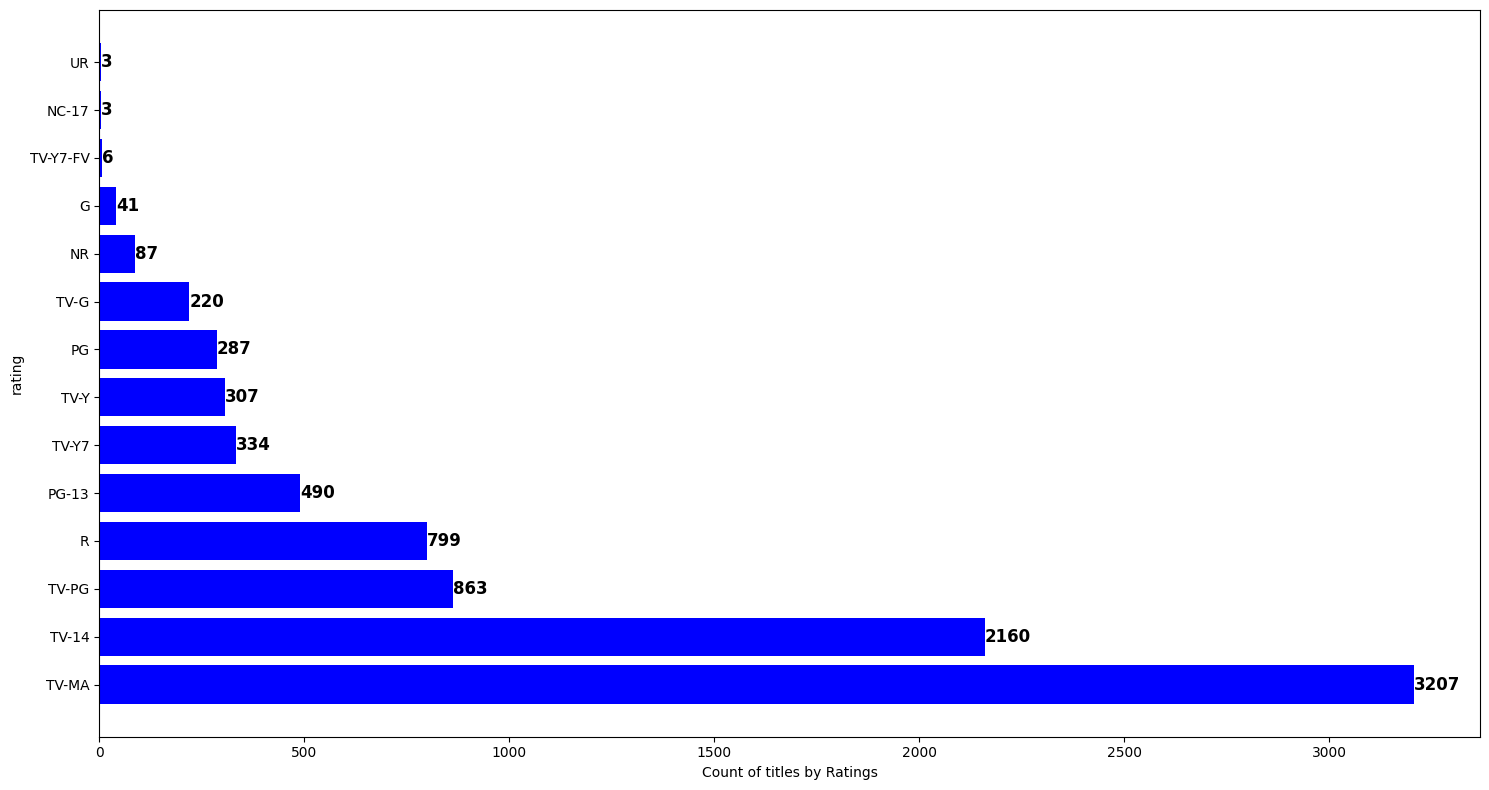

In [ ]:
df1 = df.groupby('rating').agg({'title': 'nunique'}).sort_values(by='title', ascending=False).reset_index()
plt.figure(figsize=(15,8))
plt.barh(df1['rating'], df1['title'], color= "b")
plt.xlabel('Count of titles by Ratings')
plt.ylabel('rating')

for index, value in enumerate(df1['title']):
    plt.text(value, index, str(value), va='center', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()

**Insight**

--> It is cleary visible that the consuption of Mature Audience content is highest followed the the content for children of age above 14

***Analysis_5***

In [ ]:
# The above chart is combined graph analyse the same for type 'Movies' and "TV SHow " Seprately

In [ ]:
movie_ratings = df.loc[df['type'] == 'Movie'].groupby('rating').agg({'title': 'nunique'}).reset_index().sort_values("title",ascending=False)
shows_ratings = df.loc[df['type'] == 'TV Show'].groupby('rating').agg({'title': 'nunique'}).reset_index().sort_values("title",ascending=False)
movie_ratings
shows_ratings

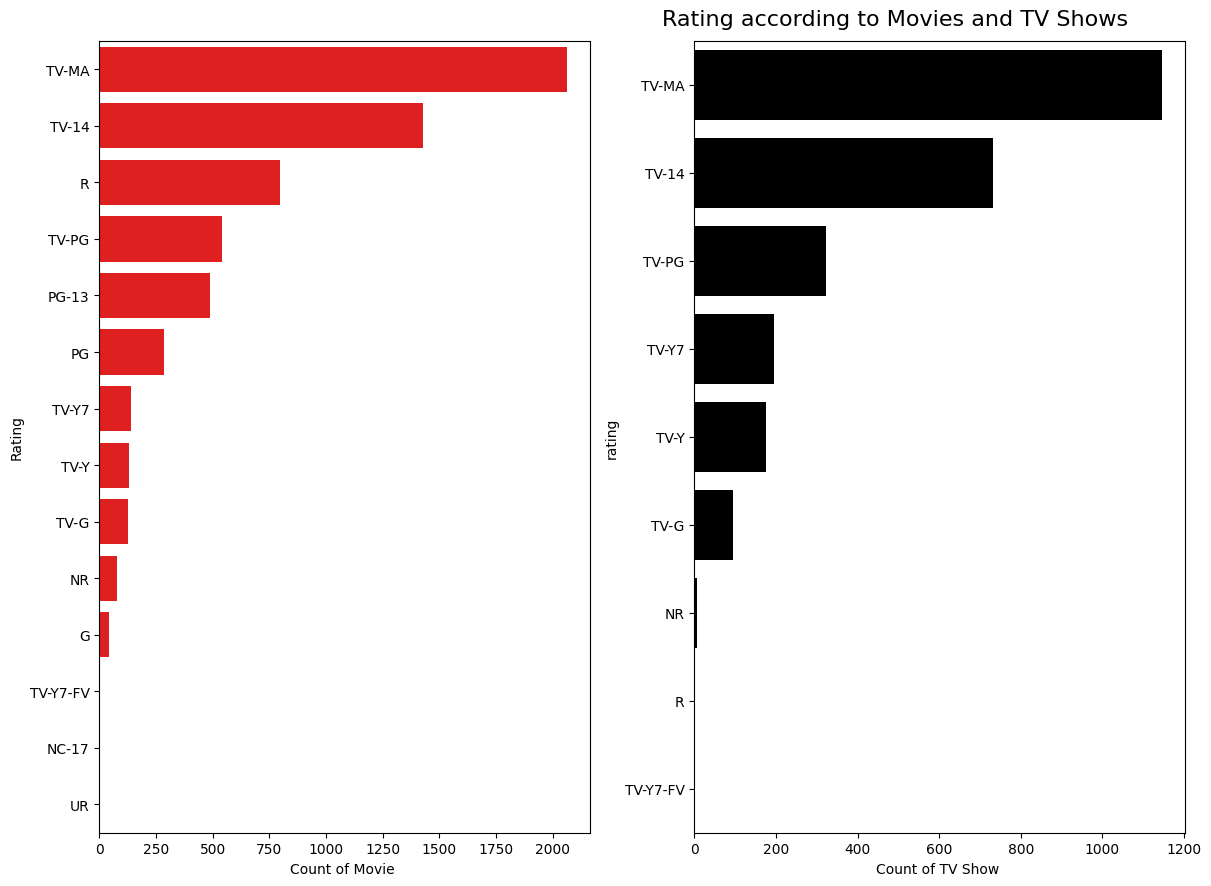

In [ ]:
# Assuming you have the 'movie_ratings' and 'shows_ratings' DataFrames from your code
plt.figure(figsize=(18, 9))
plt.suptitle('Rating according to Movies and TV Shows', fontsize=16)
# Subplot 1: Movie Ratings
plt.subplot(1, 3, 1)
sns.barplot(data=movie_ratings, y='rating', x='title', color='red')
plt.xlabel('Count of Movie ')
plt.ylabel('Rating')

# Subplot 2: TV Show Ratings
plt.subplot(1, 3, 2)
sns.barplot(data=shows_ratings, y='rating', x='title', color='black')
plt.xlabel('Count of TV Show ')

plt.tight_layout()
plt.show()

**Insight**

 Even on the Individual scale of movies or TV shows the content thats rated TV MA and TV 14 are the most consumed content in the bigger picture

***Analysis_6***

In [ ]:
# Analysis based on duration
df.groupby('duration').agg({'title': 'nunique'}).sort_values(by='title', ascending= False)

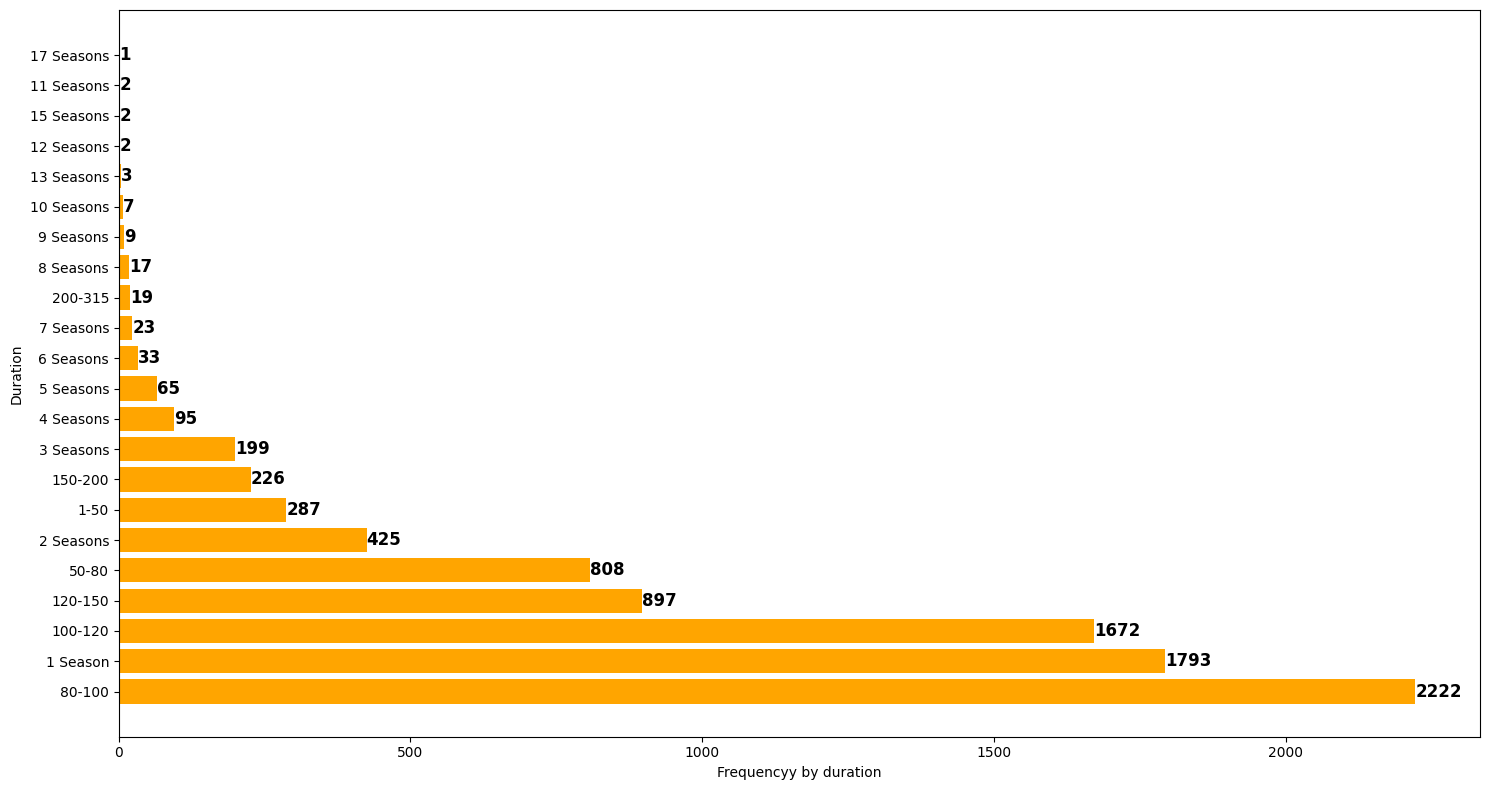

In [ ]:
df1 = df.groupby('duration').agg({'title': 'nunique'}).sort_values(by='title', ascending= False).reset_index()
plt.figure(figsize=(15,8))
plt.barh(df1['duration'], df1['title'], color= "orange")
plt.xlabel('Frequencyy by duration')
plt.ylabel('Duration')

for index, value in enumerate(df1['title']):
    plt.text(value, index, str(value), va='center', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()

**Insight**

--> In the movie category the content produced in range of 80-100 min works the most and for the TV SHOWS , shows with only 1 season seems to be the working model

***Analysis_7***

In [ ]:
# Analysis of distinct titles on the basix of cast(actors)
df.groupby(['cast']).agg({'title': 'nunique'})
df_actor = df.groupby(['cast']).agg({'title': 'nunique'}).reset_index().sort_values(by ='title', ascending = False).head(30)
df_actors = df_actor.loc[df_actor['cast'] != "Unknown Actor"]
# df_actors  = df_actor.loc[df_actor['Actors'] != 'unknown Actors']

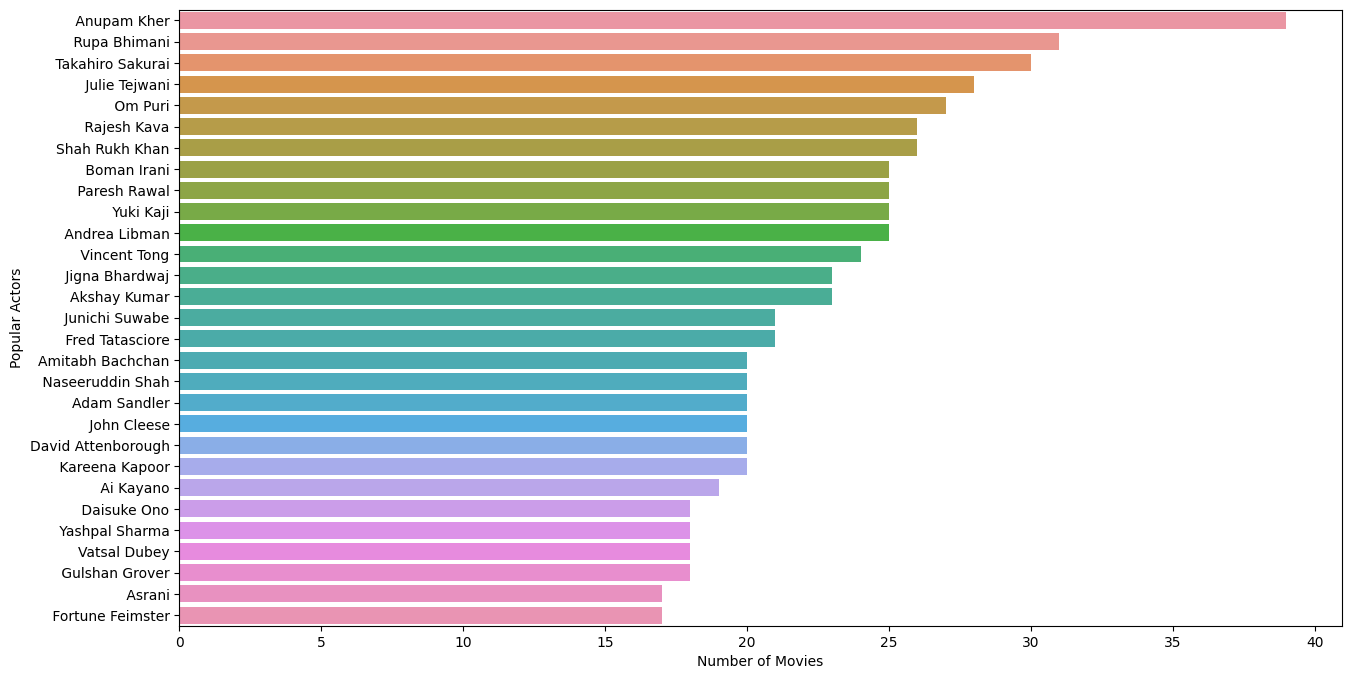

In [ ]:

plt.figure(figsize=(15,8))
sns.barplot(y = df_actors['cast'], x= df_actors['title'])
plt.xlabel('Number of Movies')
plt.ylabel('Popular Actors')
plt.show()

**Insight**

--> Anupam Kher tops the actors list in terms of the Number of movies

***Analysis_8***

In [ ]:
# number of distinct title on the basis of directors
df.groupby('director').agg({'title': 'nunique'}).reset_index().sort_values(by ='title', ascending = False)

In [ ]:
df_director = df.groupby('director').agg({'title': 'nunique'}).reset_index().sort_values(by ='title', ascending = False).head(30)
df_director = df_director.loc[df_director['director'] != 'Unknown Director']

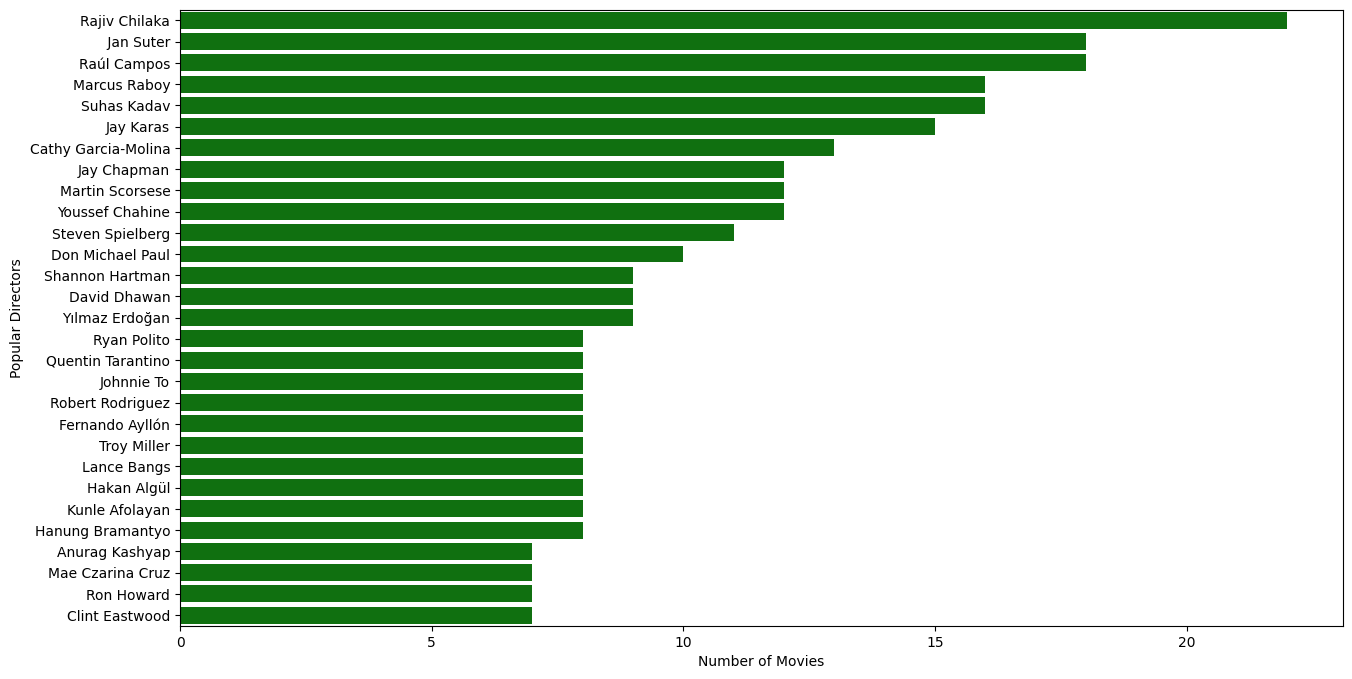

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(y = df_director['director'], x= df_director['title'],color = 'green')
plt.xlabel('Number of Movies')
plt.ylabel('Popular Directors')
plt.show()

**Insight**

--> Rajiv Chilaka tops the list with more than 20 movies followed by Jan suter and Raul Campos

***Analysis_9***

In [ ]:
# Year wise analysis of the content uploaded
df.groupby('year').agg({'title': 'nunique'}).reset_index().sort_values("title",ascending=False)
df.groupby('year').agg({'title': 'nunique'}).plot()
plt.show()

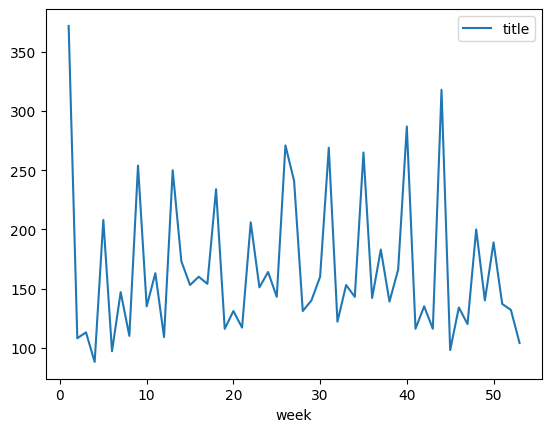

In [ ]:
df.groupby('week').agg({'title': 'nunique'}).reset_index().sort_values("title",ascending=False)
df.groupby('week').agg({'title': 'nunique'}).plot()
plt.show()

**Insight**

--> Maximum number of movies added was in between year 2018 to 2020 ,where 2020 tops the list followed by a dip in the pattern.

--> First week of the year is the week with maximum number of movies and TV Shows

# **Univariate Analysis**

Taking TV SHOWS and MOVIES as Individual Category

In [ ]:
df_shows  = df.loc[df['type'] == 'TV Show']
df_movies = df.loc[df['type'] == 'Movie']

***Analysis_10.1***

In [ ]:
# Univariate Analysis in listed_in(Genre) for TV Shows and Movies
df_genre = df_shows.groupby('listed_in').agg({'title': 'nunique'}).reset_index().sort_values(by='title', ascending = False)
plt.figure(figsize=(15,8))
sns.barplot(y = df_genre['listed_in'], x= df_genre['title'],color = 'yellow')
plt.xlabel('Number of TV Shows')
plt.ylabel('listed_in(Genre)')
plt.title('TV shows  Data')
plt.show()

**Insight**

--> International Tv SHOWS folowed by TV Dramas and TV comedy tops the chart, Kids TV and Crime stories are also one of major contributors

In [ ]:
df_genre = df_movies.groupby('listed_in').agg({'title': 'nunique'}).reset_index().sort_values(by='title', ascending = False)
plt.figure(figsize=(15,8))
sns.barplot(y = df_genre['listed_in'], x= df_genre['title'],color = 'orange')
plt.xlabel('Number of Movies')
plt.ylabel('listed_in(Genre)')
plt.title(' Movies Data')
plt.show()

**Insight**

--> Similar to the TV show genre International movies tops the chart followed by the Drama and comedy

***Analysis_10.2***

In [ ]:
# Univariate Analysis in country for TV Shows and Movies

df_countries_shows = df_shows.groupby('country').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False).head(20)
plt.figure(figsize=(15,8))
sns.barplot(y = df_countries_shows['country'], x= df_countries_shows['title'],color = 'Gold')
plt.xlabel('Number of Movies')
plt.ylabel('Countires')
plt.title('TV Shows data on Country')
plt.show()

**Insight**

--> US tops the list for the TV shows followed by UK and Japan

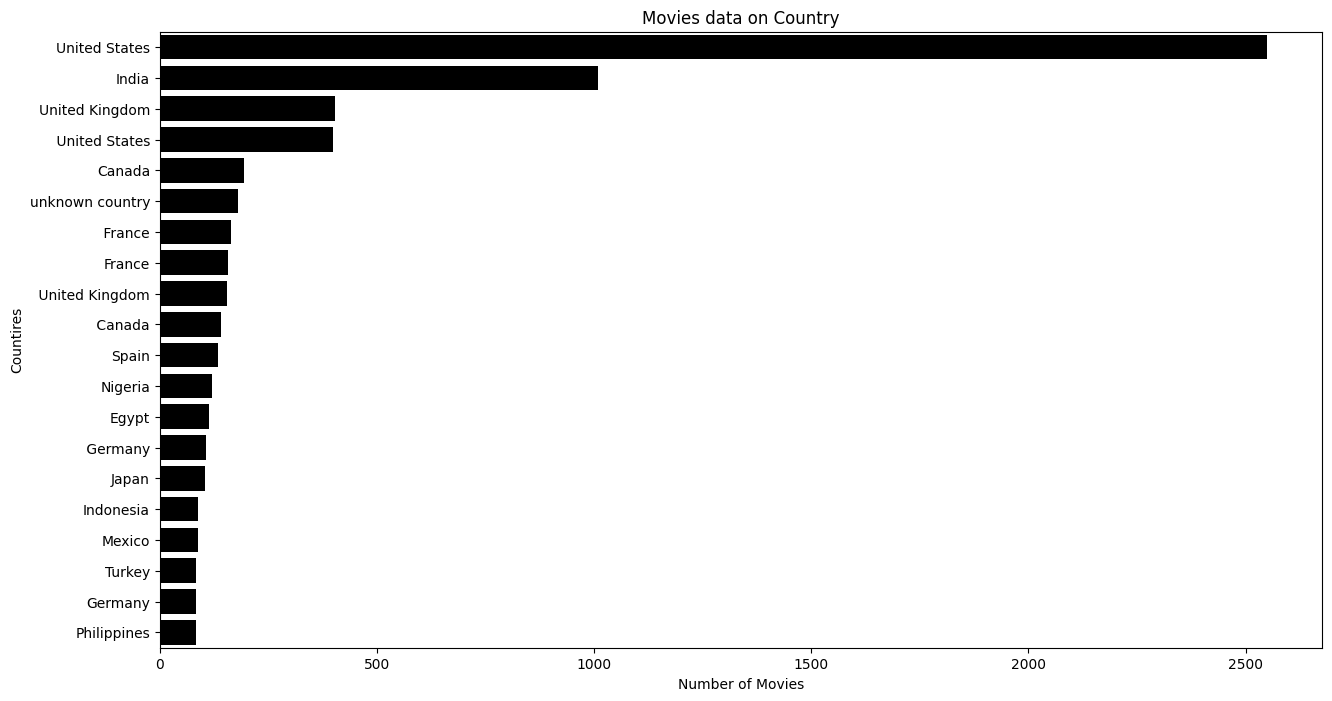

In [ ]:
df_countries_movies = df_movies.groupby('country').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False).head(20)
plt.figure(figsize=(15,8))
sns.barplot(y = df_countries_movies['country'], x= df_countries_movies['title'],color = 'Black')
plt.xlabel('Number of Movies')
plt.ylabel('Countires')
plt.title('Movies data on Country')
plt.show()

**Insight**

--> US tops the list for the movies as well followed by India and UK

--> Its seen that US tops both the lists but Bollywood giving immense amount of movies per year makes the over all content at number two (combing TV shows and Movies)

***Analysis_10.3***

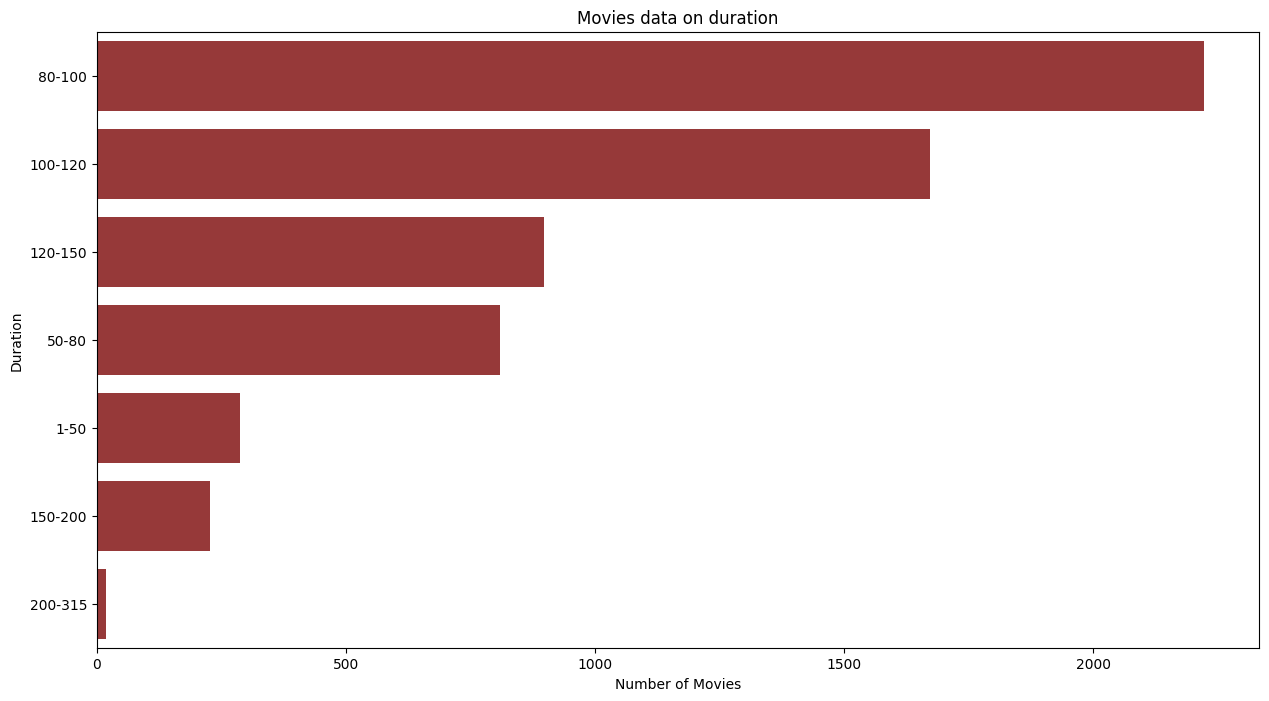

In [ ]:
#  Univariate Analysis w.r.t duration of  Movies
df_duration_movies = df_movies.groupby('duration').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False)
plt.figure(figsize=(15,8))
sns.barplot(y = df_duration_movies['duration'], x= df_duration_movies['title'],color='brown')
plt.xlabel('Number of Movies')
plt.ylabel('Duration')
plt.title('Movies data on duration')
plt.show()

**Insight**

--> Its clearly visible from the graph that the movies with duration 50 to 100 min of range conatins most of the watched movies below 50 min it falls down

--> There is a rise in the Number of movies when the duration crosses the limit of 150 min and is below 200 min after 200 min there is a big dip in the number of movies

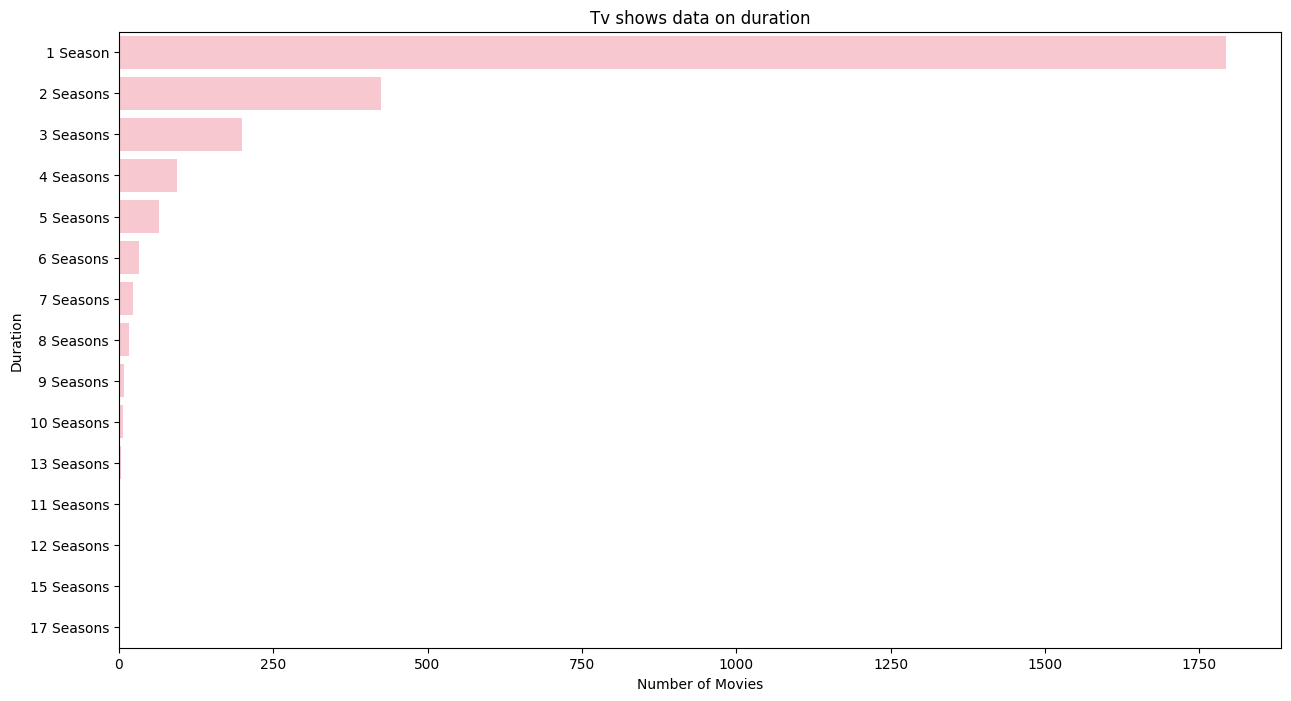

In [ ]:
# Univariate Analysis w.r.t duration  of TV Shows data
df_duration_tvshows = df_shows.groupby('duration').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False)
plt.figure(figsize=(15,8))
sns.barplot(y = df_duration_tvshows['duration'], x= df_duration_tvshows['title'],color='pink')
plt.xlabel('Number of Movies')
plt.ylabel('Duration')
plt.title('Tv shows data on duration')
plt.show()

**Insight**

--> There is a clear approximately Invers relationhip between number of seasons and the Count of TV SHOWS . Shows with only one season tops the list clearly

***Analysis_10.4***

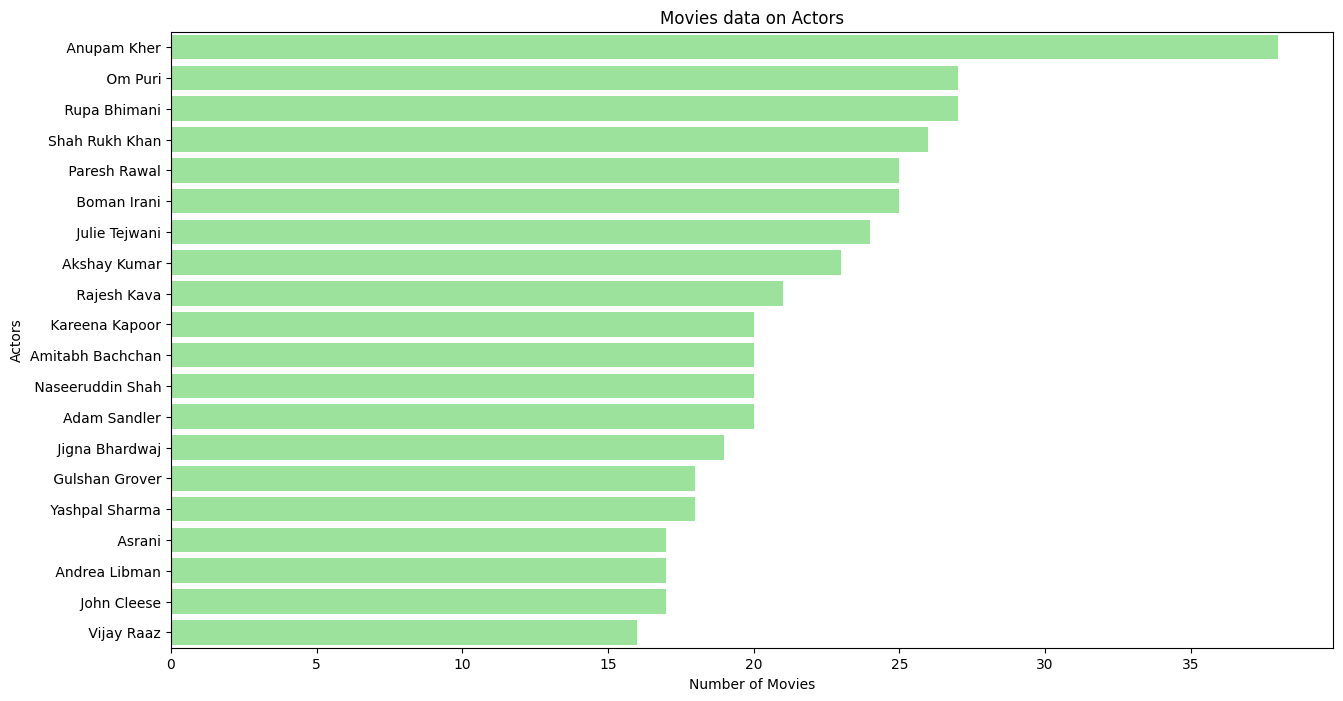

In [ ]:
# Univariate Analysis w.r.t Actors  of movies data
df_Actors_movies = df_movies.groupby('cast').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False)
plt.figure(figsize=(15,8))
df_Actors_movies = df_Actors_movies.loc[df_Actors_movies['cast']!= 'Unknown Actor'].head(20)
sns.barplot(y = df_Actors_movies['cast'], x= df_Actors_movies['title'],color='lightGreen')
plt.xlabel('Number of Movies')
plt.ylabel('Actors')
plt.title('Movies data on Actors')
plt.show()

**Insight**

--> Indian Actors Like Anupam Kher , OM puri and Shahrukh khan lies on the top of the list in case of movies where Anupam Kher tops the list

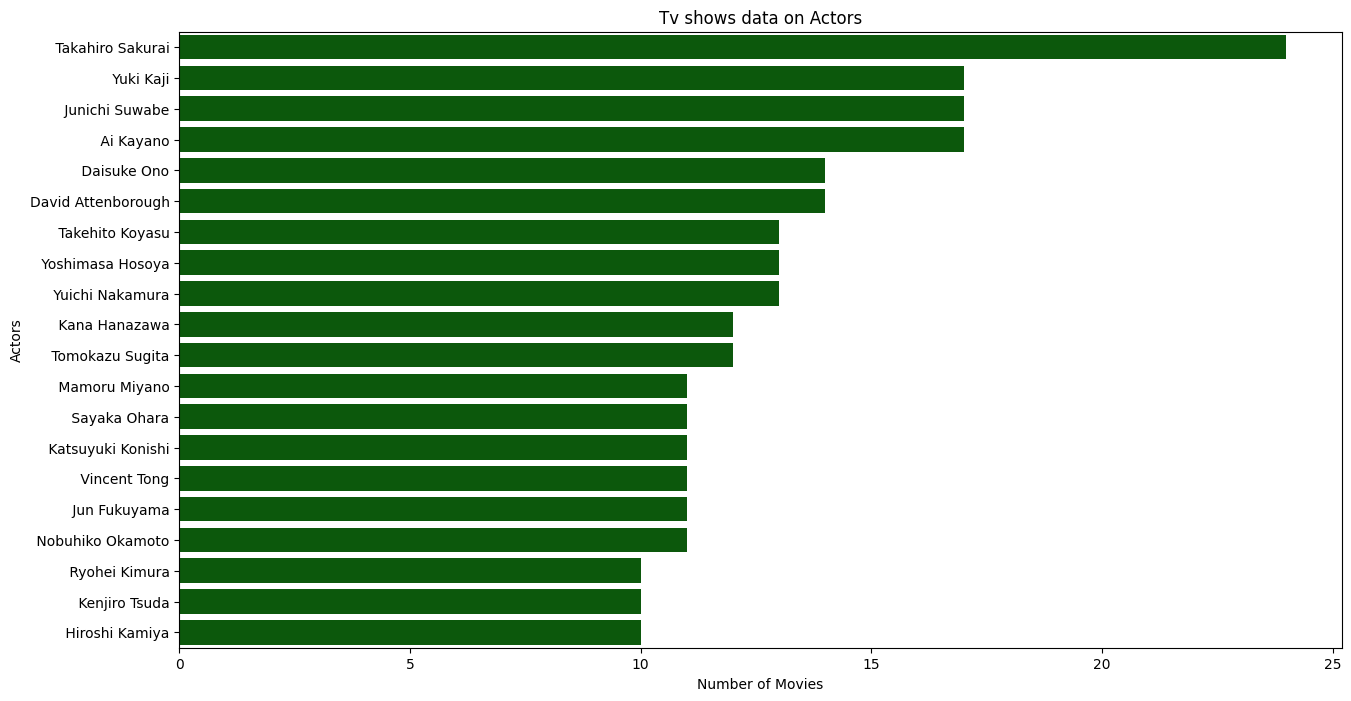

In [ ]:
df_Actors_tvshows = df_shows.groupby('cast').agg({'title':'nunique'}).reset_index().sort_values('title', ascending = False)
plt.figure(figsize=(15,8))
df_Actors_tvshows = df_Actors_tvshows.loc[df_Actors_tvshows['cast']!= 'Unknown Actor'].head(20)
sns.barplot(y = df_Actors_tvshows['cast'], x= df_Actors_tvshows['title'],color='darkgreen')
plt.xlabel('Number of Movies')
plt.ylabel('Actors')
plt.title('Tv shows data on Actors')
plt.show()

**Insight**

-->Takahiro Sakurai,Yuki Kaji and other South Korean/Japanese actors are the most popular actors across TV Shows

--> There is no sharp dip here in case of TV shows which reflects that the there is more diversity in the cast of actors for TV SHOWS

***Analysis_10.5***

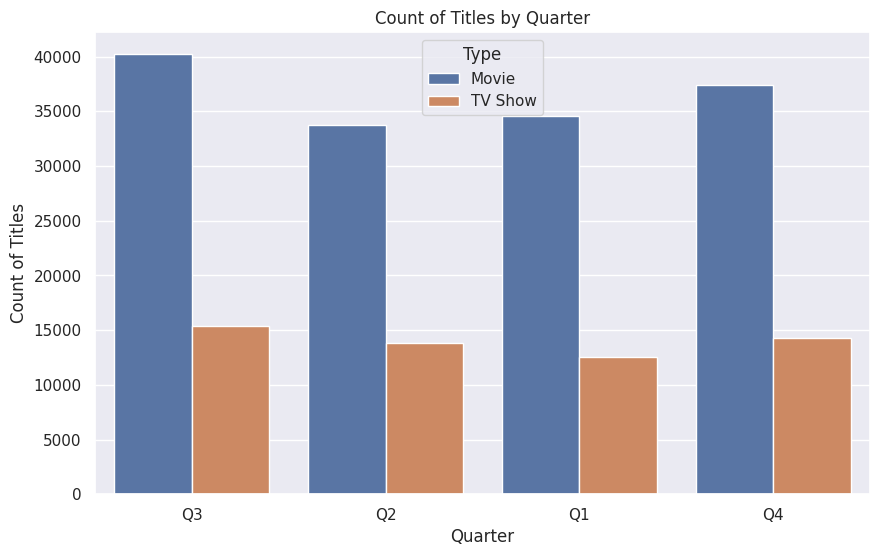

In [ ]:
# Quarterly Analysis of Movies and TV Shows
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x='quarter', hue='type')
plt.xlabel('Quarter')
plt.ylabel('Count of Titles')
plt.title('Count of Titles by Quarter')
plt.legend(title='Type')
plt.show()

**Insight**

-->There is not much diffrenece in the Quarterly perfromance in case of TV SHOWS

--> Movies shows a bit of improved permoance in the third and fourth quarter

# **Recommendations**


1.An approximate duration of 100 mins in movies works the best for movies and TV Shows with 1 Season has given the maximum output so it should be kept in mind for  content release on NETFLIx

2.Movies released in the End of a year or Begginning of the new year performed best so that should be the criteria of release

3.Recommendation for mature adience content specially in India and USA which gives the most of the content.

4.Countries Like Japan and South Korea leads in terms of Anime and Kids content as well so more preference to it should be given for the release

5.In Order to grow buisness in India Actors in top list like SRK and Anupam Kher proviedes more buisness so content of these top actors should be given in preference

6.Although there will be demand for the local content but International Movies and TV Shows tops the list in terms of count and so in revenue so focus should be on International content

7.